# Assignment 4: Build a Supervised Autoencoder.

### Name: Ayomide Akinsanya

### Due Date: Tuesday 5/3/2022 11:59PM


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Build a standard dense autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

11501568/11490434 [==============================] - 0s 0us/step
Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottlenect layer with 2 as  output size. 
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model (20 points)

In [4]:
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 =  Dense(100)(input_img)
encode2 =  Dense(50)(encode1)
encode3 =  Dense(25)(encode2)

bottleneck = Dense(2)(encode3)

decode1 =  Dense(25)(bottleneck)
decode2 =  Dense(50)(decode1)
decode3 =  Dense(100)(decode2)
decode4 =  Dense(784)(decode3)


ae = models.Model(input_img, decode4)

ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 2)                 52        
                                                                 
 dense_4 (Dense)             (None, 25)                75        
                                                                 
 dense_5 (Dense)             (None, 50)                1300  

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters (5 points)

In [6]:
from tensorflow.keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 7s 20ms/step - loss: 0.0720 - val_loss: 0.0603
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 0.0599 - val_loss: 0.0600
Epoch 3/100
79/79 [==============================] - 1s 18ms/step - loss: 0.0593 - val_loss: 0.0600
Epoch 4/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0589 - val_loss: 0.0596
Epoch 5/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0584 - val_loss: 0.0585
Epoch 6/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0580 - val_loss: 0.0590
Epoch 7/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0573 - val_loss: 0.0592
Epoch 8/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0569 - val_loss: 0.0579
Epoch 9/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0567 - val_loss: 0.0574
Epoch 10/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0567 - val_loss: 0.0576


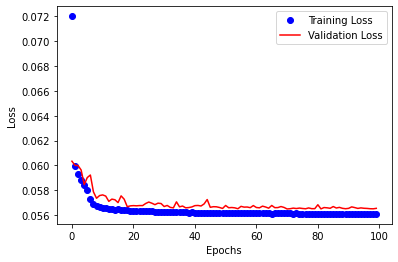

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images (5 points)

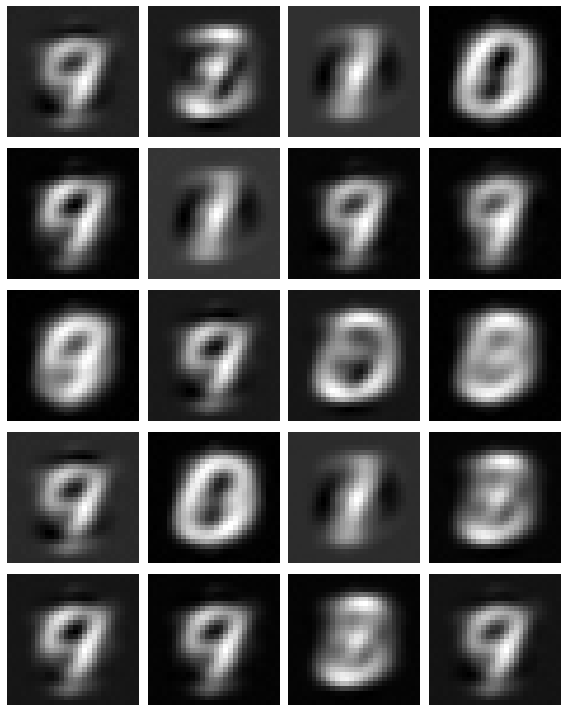

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 1s 3ms/step - loss: 0.0559
loss = 0.05585844814777374


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 2)                 52        
                                                                 
Total params: 84,877
Trainable params: 84,877
Non-trainable params: 0
_________________________________________________________________


In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


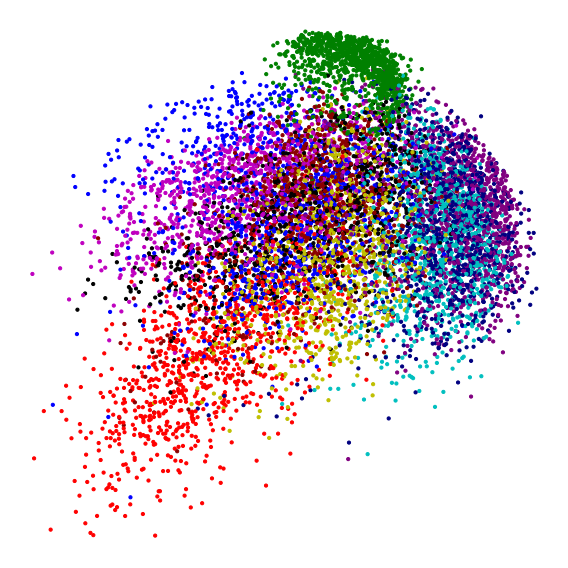

In [13]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [15]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden1 = Dropout(0.5)(hidden1)
hidden2 = Dense(128, activation='relu')(hidden1)
hidden2 = Dropout(0.5)(hidden2)
hidden2 = BatchNormalization()(hidden2)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

"""classifier1 = Dense(128, activation='relu')(bottleneck)
classifier1 = BatchNormalization()(classifier1)
classifier2 = Dense(128, activation='relu')(classifier1)
classifier2 = Dropout(0.5)(classifier2)
classifier3 = Dense(10, activation='softmax')(classifier2)"""

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 128)               384       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                                 
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


"classifier1 = Dense(128, activation='relu')(bottleneck)\nclassifier1 = BatchNormalization()(classifier1)\nclassifier2 = Dense(128, activation='relu')(classifier1)\nclassifier2 = Dropout(0.5)(classifier2)\nclassifier3 = Dense(10, activation='softmax')(classifier2)"

In [16]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-3),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


313/313 [==============================] - 3s 7ms/step - loss: 1.5463 - acc: 0.3963 - val_loss: 1.3701 - val_acc: 0.4418
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 1.3943 - acc: 0.4343 - val_loss: 1.3421 - val_acc: 0.4541
Epoch 3/30
313/313 [==============================] - 2s 6ms/step - loss: 1.3712 - acc: 0.4435 - val_loss: 1.3336 - val_acc: 0.4559
Epoch 4/30
313/313 [==============================] - 3s 8ms/step - loss: 1.3627 - acc: 0.4489 - val_loss: 1.3254 - val_acc: 0.4607
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 1.3586 - acc: 0.4507 - val_loss: 1.3205 - val_acc: 0.4679
Epoch 6/30
313/313 [==============================] - 3s 8ms/step - loss: 1.3474 - acc: 0.4500 - val_loss: 1.3229 - val_acc: 0.4623
Epoch 7/30
313/313 [==============================] - 2s 7ms/step - loss: 1.3510 - acc: 0.4543 - val_loss: 1.3160 - val_acc: 0.4701
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss: 1.3439 - acc:

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network (30 points)

In [17]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network

encode1 =  Dense(100,activation='relu')(input_img)
encode1 =  Dropout(0.5)(encode1)
#encode1 =  BatchNormalization()(encode1)
encode2 =  Dense(100,activation='relu')(encode1)
#encode2 =  Dropout(0.5)(encode2)
#encode2 =  BatchNormalization()(encode2)
encode3 =  Dense(10, activation='relu')(encode2)

# The width of the bottleneck layer must be exactly 2.

bottleneck = Dense(2)(encode3)

# decoder network
decode1 =  Dense(10, activation='relu')(bottleneck)
#decode1 =  Dropout(0.5)(decode1)
#decode1 =  BatchNormalization()(decode1)
decode2 =  Dense(100,activation='relu')(decode1)
#decode2 =  Dropout(0.5)(decode2)
decode2 =  BatchNormalization()(decode2)
decode3 =  Dense(100,activation='relu')(decode2)
decode3 =  BatchNormalization()(decode3)
decode4 =  Dense(784)(decode3)



# build a classifier upon the bottleneck layer
classifier1 = Dense(128, activation='relu')(bottleneck)
classifier1 = BatchNormalization()(classifier1)
classifier2 = Dense(128, activation='relu')(classifier1)
classifier2 = Dropout(0.5)(classifier2)
classifier3 = Dense(10, activation='softmax')(classifier2)

In [18]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 784)]        0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 100)          78500       ['input_img[0][0]']              
                                                                                                  
 dropout_1 (Dropout)            (None, 100)          0           ['dense_11[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 100)          10100       ['dropout_1[0][0]']              
                                                                                            

In [19]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [20]:
from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


313/313 [==============================] - 8s 16ms/step - loss: 0.8111 - dense_18_loss: 0.0738 - dense_21_loss: 1.4745 - val_loss: 0.6316 - val_dense_18_loss: 0.0645 - val_dense_21_loss: 1.1343
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5010 - dense_18_loss: 0.0581 - dense_21_loss: 0.8858 - val_loss: 0.3367 - val_dense_18_loss: 0.0583 - val_dense_21_loss: 0.5567
Epoch 3/100
313/313 [==============================] - 4s 14ms/step - loss: 0.4052 - dense_18_loss: 0.0566 - dense_21_loss: 0.6973 - val_loss: 0.2751 - val_dense_18_loss: 0.0554 - val_dense_21_loss: 0.4393
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 0.3583 - dense_18_loss: 0.0558 - dense_21_loss: 0.6051 - val_loss: 0.2536 - val_dense_18_loss: 0.0548 - val_dense_21_loss: 0.3975
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 0.3315 - dense_18_loss: 0.0553 - dense_21_loss: 0.5525 - val_loss: 0.2329 - val_dense_18_loss: 0.0540 - val_dens

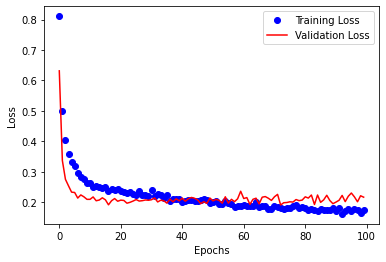

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question  (10 points)

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

### 4.3. Visualize the reconstructed test images

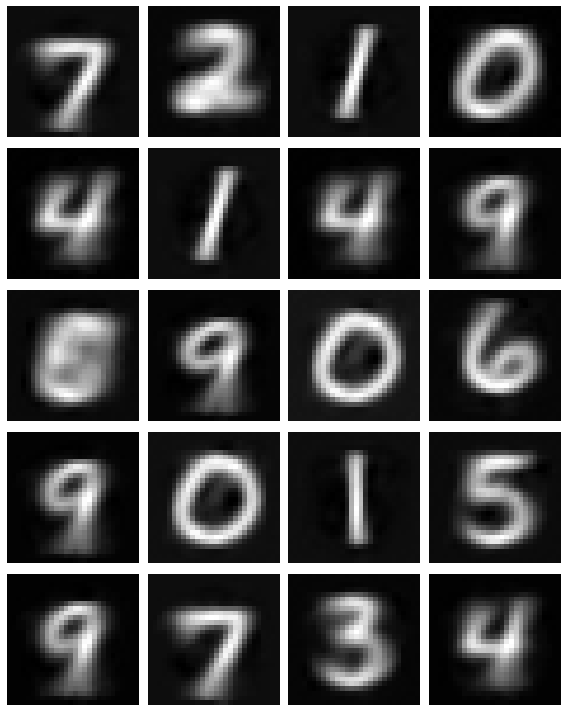

In [22]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features



In [23]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 dense_11 (Dense)            (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
 dense_14 (Dense)            (None, 2)                 22        
                                                                 
Total params: 89,632
Trainable params: 89,632
Non-trainable

Shape of encoded_test: (10000, 2)


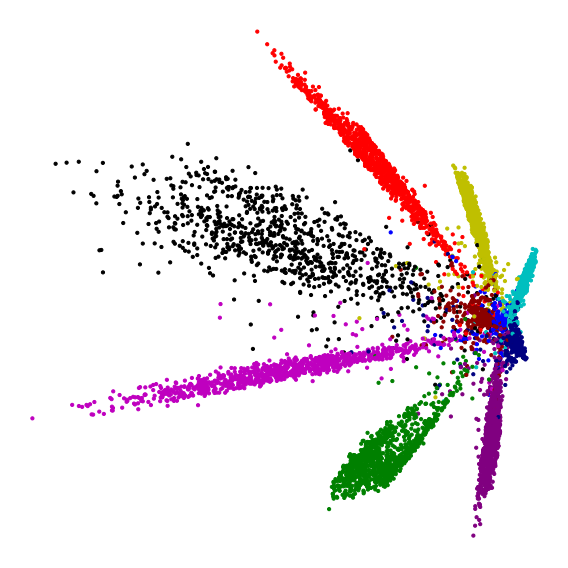

In [24]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [25]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [26]:
# build a classifier which takes the 2D features as input
from keras.layers import *
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_22 (Dense)            (None, 128)               384       
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 10)                1290      
                                                                 
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [27]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


313/313 [==============================] - 3s 8ms/step - loss: 0.9793 - acc: 0.6802 - val_loss: 0.6246 - val_acc: 0.8380
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 0.3888 - acc: 0.9259 - val_loss: 0.4610 - val_acc: 0.9395
Epoch 3/30
313/313 [==============================] - 2s 6ms/step - loss: 0.2323 - acc: 0.9818 - val_loss: 0.3975 - val_acc: 0.9415
Epoch 4/30
313/313 [==============================] - 2s 8ms/step - loss: 0.1500 - acc: 0.9821 - val_loss: 0.3712 - val_acc: 0.9405
Epoch 5/30
313/313 [==============================] - 2s 8ms/step - loss: 0.1086 - acc: 0.9820 - val_loss: 0.3585 - val_acc: 0.9420
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0897 - acc: 0.9827 - val_loss: 0.3528 - val_acc: 0.9423
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0808 - acc: 0.9829 - val_loss: 0.3490 - val_acc: 0.9438
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0757 - acc:

#### Remark: (10 points)

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [28]:
# evaluate your model on the never-seen-before test data
# write your code here:
loss = classifier.evaluate(f_te, y_test_vec)

print('Accuracy:', loss[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3172 - acc: 0.9477
Accuracy: 0.947700023651123
